# TLS Characterization of UA Q4
### using Experiment and Analysis classes

In [ ]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script
from qm.octave import *
from qm.octave.octave_manager import ClockMode
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qualang_tools.units import unit
from qm.octave import QmOctaveConfig
from set_octave import ElementsSettings, octave_settings
from quam import QuAM
from scipy.io import savemat, loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 3 # for UA Q4
res_index = 3 # for UA Q4
flux_index = 3 # for UA Q4
TLS_index = 0

In [128]:
Experiment = ExperimentHandle()
Analysis = AnalysisHandle()
machine = Analysis.get_machine()

In [67]:
# initialize Labber-controlled hardware
Experiment.set_Labber(Analysis.get_machine(), qubit_index, res_index, flux_index)
# set octave to external clock
#Experiment.set_external_clock()

In [68]:
# this updates the octave settings, including rf_gain and rf_output_mode
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)

2024-02-29 14:00:18,598 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-29 14:00:18,608 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r3 for (LO, IF) = (6.930 GHz, -50.000 MHz)
2024-02-29 14:00:25,844 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q3 for (LO, IF) = (5.967 GHz, -50.000 MHz)
2024-02-29 14:00:39,163 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


# TLS experiments

## Set TLS index

In [39]:
TLS_index = 0

## TLS T1

In [127]:
# set to qubit freq
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[0] + 0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50E6
machine = Analysis.set_machine(machine)

In [70]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine,calibration_flag = True)

2024-02-29 14:00:55,721 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-29 14:00:55,730 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r3 for (LO, IF) = (6.930 GHz, -50.000 MHz)
2024-02-29 14:01:03,419 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q3 for (LO, IF) = (5.966 GHz, -50.000 MHz)
2024-02-29 14:01:16,242 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [71]:
%matplotlib qt
tau_sweep_abs = np.arange(200,1000E3+1,1E4)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.TLS_T1(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index,
                   n_avg = 5E3, cd_time_qubit = 20E3, cd_time_TLS = 1500E3, simulate_flag = False, simulation_len = 15_000, plot_flag = True)

Execution stopped by user!#####                              ] 41.9% (n=2093/5000.0) --> elapsed time: 425.99s


Qubit T1 [us]: 166.4598061553065


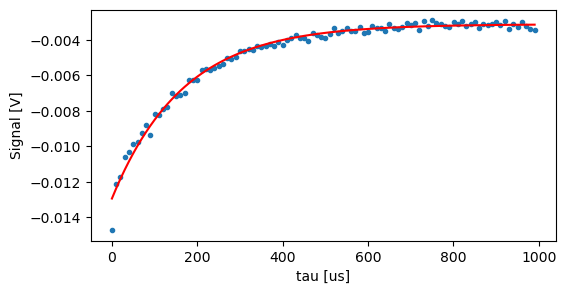

In [73]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")

# TLS drive

## TLS spectroscopy

### This cell is only for the first run, to estimate TLS freq

In [11]:
TLS_index = 0

In [90]:
# TLS freq estimate based on SWAP flux amplitude
TLS_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[flux_index].iswap.level[TLS_index])
TLS_freq_est = np.round(TLS_freq_est * 1E6)
if len(machine.qubits[qubit_index].f_tls) < TLS_index + 2: # need to increase size
    machine.qubits[qubit_index].f_tls.append(int(TLS_freq_est.item()) + 0E6)
    machine.qubits[qubit_index].lo = int(TLS_freq_est.item()) - 200E6
else: # just update the value
    machine.qubits[qubit_index].f_tls[TLS_index+1] = (int(TLS_freq_est.item()))
    machine.qubits[qubit_index].lo = int(TLS_freq_est.item()) - 200E6
machine = Analysis.set_machine(machine)

### This is when we already have calibrated TLS freq saved somewhere

In [74]:
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[TLS_index+1] + 0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 - 200E6
machine = Analysis.set_machine(machine)

In [75]:
# calibrate octave for TLS sweep
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine = machine,calibration_flag = True)

2024-02-29 14:09:17,127 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-29 14:09:17,141 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r3 for (LO, IF) = (6.930 GHz, -50.000 MHz)
2024-02-29 14:09:25,154 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q3 for (LO, IF) = (5.559 GHz, 200.000 MHz)
2024-02-29 14:09:37,122 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [111]:
%matplotlib qt
TLS_freq_sweep = machine.qubits[qubit_index].f_tls[TLS_index+1] + np.arange(-7E6,7E6+1,0.25E6)
machine, TLS_freq_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_freq(TLS_freq_sweep, qubit_index, res_index, flux_index, TLS_index,
                  n_avg = 10E3, cd_time_qubit = 20E3, cd_time_TLS = 1000E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 582.07s


resonant frequency: 5759.790 MHz


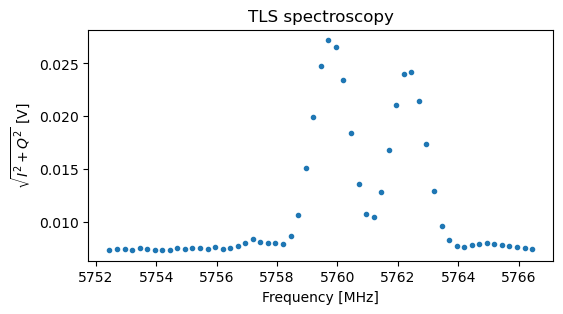

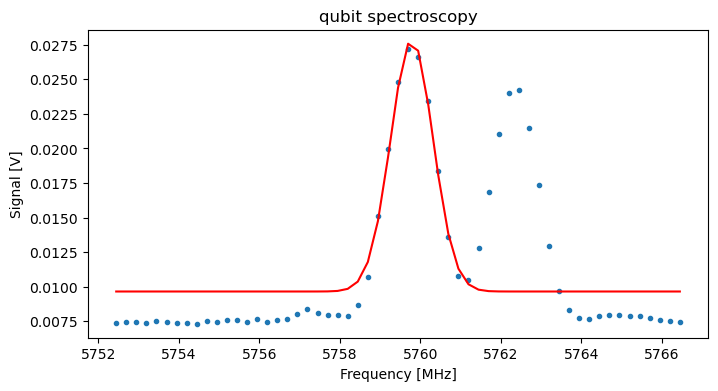

Execution stopped by user!


In [112]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=TLS_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
# update TLS freq
machine.qubits[qubit_index].f_tls[TLS_index+1] = qubit_freq + 0E6
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq - 200E6
# save the parameters
machine = Analysis.set_machine(machine)

## TLS rabi

In [ ]:
machine.flux_lines[flux_index].iswap.level[TLS_index] = 0.219
machine = Analysis.set_machine(machine)

In [ ]:
machine.qubits[qubit_index].pi_amp_tls[TLS_index] = 0.45267857
machine = Analysis.set_machine(machine)

In [108]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 70 + 0.1, 1)  # in units of clock cyles
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, TLS_index,
                  n_avg = 5E3, cd_time_qubit = 20E3, cd_time_TLS = 1000E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 341.89s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 341.97s


T2rabi: 346.6 ns
rabi_pi_pulse: 20.9 ns
half period: 219.99 ns


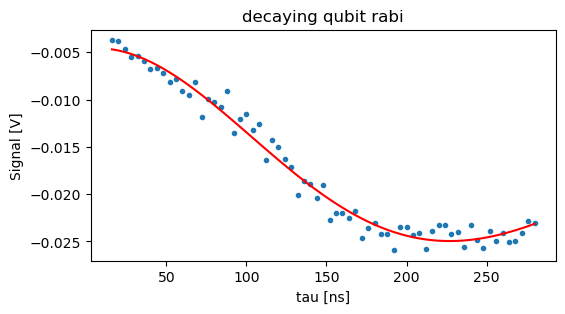

In [110]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,method = "decaying_time_rabi", plot_flag = True)

In [88]:
if len(machine.qubits[qubit_index].pi_length_tls) < TLS_index + 1: # need to increase size
    machine.qubits[qubit_index].pi_length_tls.append(200)
else: # just update the value
    machine.qubits[qubit_index].pi_length_tls[TLS_index] = 200
    
machine = Analysis.set_machine(machine)

## TLS Power Rabi

In [103]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.5, 1.3, 0.03) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.TLS_rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, TLS_index = TLS_index,  
                                          n_avg = 5E3, cd_time_qubit = 20E3, cd_time_TLS = 1500E3, plot_flag = False, machine = machine)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 608.36s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 608.39s


rabi_pi_pulse_amp: 0.06857 V
half period: 0.0754298 V


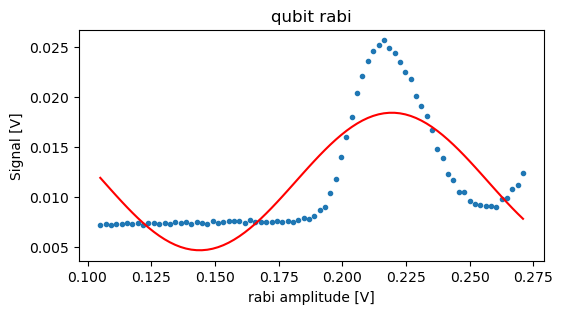

In [106]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [107]:
pi_pulse_amp = 0.216
if len(machine.qubits[qubit_index].pi_length_tls) < TLS_index + 1: # need to increase size
    machine.qubits[qubit_index].pi_amp_tls.append(pi_pulse_amp)
else: # just update the value
    machine.qubits[qubit_index].pi_amp_tls[TLS_index] = pi_pulse_amp
machine = Analysis.set_machine(machine)

## TLS Ramsey

In [29]:
%matplotlib qt
ramsey_duration_sweep = np.arange(4, 400 + 0.1, 5)  # in units of clock cyles
machine, ramsey_duration_sweep, sig_I = Experiment.exp1D.Ramsey.TLS_ramsey(ramsey_duration_sweep, qubit_index, res_index, flux_index, TLS_index,
          n_avg = 5E3, detuning = 2E6, cd_time_qubit = 20E3, cd_time_TLS = 1000E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 408.50s
Execution stopped by user!


Qubit T2* [ns]: 503.0456651289249
Detuning [MHz]: 5.954226871298722
Exponent n: 1.2011861459739182


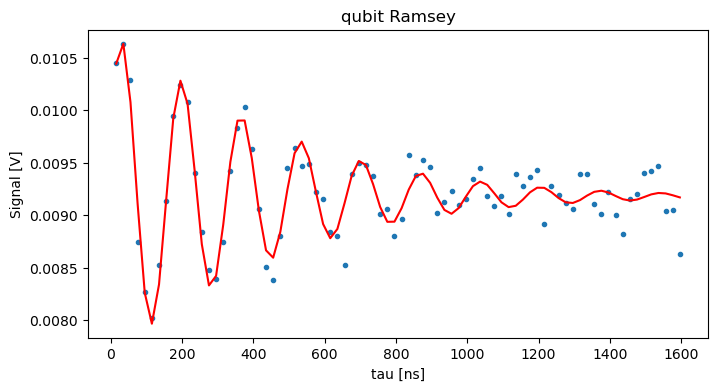

In [30]:
%matplotlib inline
q_T2star = Analysis.exp1D.ramsey(ramsey_duration_sweep, sig_I,plot_flag = True)

## TLS T1 with direct driving

In [113]:
%matplotlib qt
tau_sweep_abs = np.arange(200,60E3+1,1E3)
machine, tau_sweep_abs, sig_I = Experiment.exp1D.T1.TLS_T1_driving(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index,
                   n_avg = 5E3, cd_time_qubit = 20E3, cd_time_TLS = 500E3, simulate_flag = False, simulation_len = 15_000, plot_flag = True)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 165.20s


Qubit T1 [us]: 5.3695700978928445


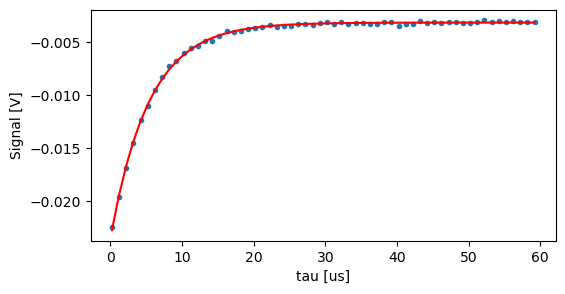

In [115]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_I,method = "exp")

# TLS Dynamical Decoupling

## TLS echo

In [ ]:
%matplotlib qt
tau_sweep = np.arange(4,800 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_echo(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          n_avg = 5E3, cd_time_qubit = 20E3, cd_time_TLS = 1500E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Qubit T1 [us]: 5046.693176964003


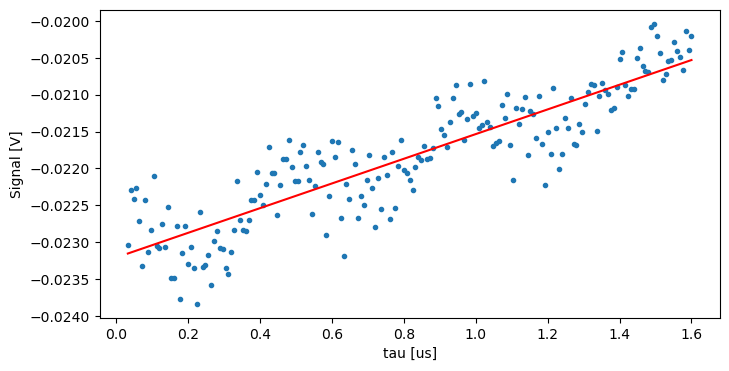

In [119]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(tau_sweep_abs*2,sig_I,method = "exp")

## TLS CPMG2

In [120]:
%matplotlib qt
tau_sweep = np.arange(4, 800 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 2, n_avg = 5E3, cd_time_qubit = 20E3, cd_time_TLS = 1500E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 6088.76s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 6088.87s
Execution stopped by user!


In [125]:
plt.plot(tau_sweep_abs, sig_I)
plt.xlabel('Tau (half pulse spacing) (ns)')
plt.ylabel('I(V)')

Text(0, 0.5, 'I(V)')

## TLS CPMG4

In [62]:
%matplotlib qt
tau_sweep = np.arange(4, 400 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 4, n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 1500E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 2425.16s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 2425.32s


## TLS CPMG6

In [63]:
%matplotlib qt
tau_sweep = np.arange(4, 400 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 6, n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 1500E3, plot_flag = False, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 2430.52s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 2430.56s


## TLS CPMG8

In [64]:
%matplotlib qt
tau_sweep = np.arange(4, 400 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 8, n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 1500E3, plot_flag = False, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 2435.95s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 2436.00s


## TLS CPMG12

In [65]:
%matplotlib qt
tau_sweep = np.arange(4, 400 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 12, n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 1500E3, plot_flag = False, simulate_flag = False, simulation_len = 20_000, machine = machine)

KeyboardInterrupt: 

## TLS CPMG16

In [ ]:
%matplotlib qt
tau_sweep = np.arange(4, 800 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 16, n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 400E3, plot_flag = False, simulate_flag = False, simulation_len = 20_000, machine = machine)

## TLS CPMG20

In [ ]:
%matplotlib qt
tau_sweep = np.arange(4, 800 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 20, n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 400E3, plot_flag = False, simulate_flag = False, simulation_len = 20_000, machine = machine)

## TLS CPMG24

In [ ]:
%matplotlib qt
tau_sweep = np.arange(4, 800 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 24, n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 400E3, plot_flag = False, simulate_flag = False, simulation_len = 20_000, machine = machine)

## TLS CPMG28

In [ ]:
%matplotlib qt
tau_sweep = np.arange(4, 800 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 28, n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 400E3, plot_flag = False, simulate_flag = False, simulation_len = 20_000, machine = machine)

## TLS CPMG32

In [ ]:
%matplotlib qt
tau_sweep = np.arange(4, 800 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 32, n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 400E3, plot_flag = False, simulate_flag = False, simulation_len = 20_000, machine = machine)